In [50]:
import pystac_client
import json
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import skimage as ski
import planetary_computer
import rasterio as rio
import numpy as np
from skimage.exposure import rescale_intensity
from rasterio.enums import Resampling
from rasterio.merge import merge

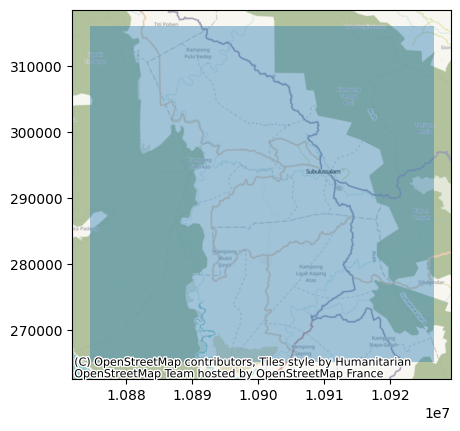

In [2]:
# Load the shapefile
roi = gpd.read_file('../data/roi/example_roi_north_sumatera.shp')

# Plot it
ax = roi.to_crs(epsg=3857).plot(alpha=0.4)
cx.add_basemap(ax)

In [36]:
# Load stac address
stac = json.load(open('../data/stac.json'))
link = stac['mpc']

# Load STAC
client = pystac_client.Client.open(link, modifier=planetary_computer.sign_inplace)

# Get liss of all collection
collections = [x for x in client.get_collections()]
collections

[<CollectionClient id=daymet-annual-pr>,
 <CollectionClient id=daymet-daily-hi>,
 <CollectionClient id=3dep-seamless>,
 <CollectionClient id=3dep-lidar-dsm>,
 <CollectionClient id=fia>,
 <CollectionClient id=sentinel-1-rtc>,
 <CollectionClient id=gridmet>,
 <CollectionClient id=daymet-annual-na>,
 <CollectionClient id=daymet-monthly-na>,
 <CollectionClient id=daymet-annual-hi>,
 <CollectionClient id=daymet-monthly-hi>,
 <CollectionClient id=daymet-monthly-pr>,
 <CollectionClient id=gnatsgo-tables>,
 <CollectionClient id=hgb>,
 <CollectionClient id=cop-dem-glo-30>,
 <CollectionClient id=cop-dem-glo-90>,
 <CollectionClient id=goes-cmi>,
 <CollectionClient id=terraclimate>,
 <CollectionClient id=nasa-nex-gddp-cmip6>,
 <CollectionClient id=gpm-imerg-hhr>,
 <CollectionClient id=gnatsgo-rasters>,
 <CollectionClient id=3dep-lidar-hag>,
 <CollectionClient id=io-lulc-annual-v02>,
 <CollectionClient id=conus404>,
 <CollectionClient id=3dep-lidar-intensity>,
 <CollectionClient id=3dep-lidar-point

In [81]:
# Parameter for search
# BBOX or boundary
bbox = roi.bounds.iloc[0]

# Look for certain ranges of date
# Use 4 months between 2024 may to 2024 august
start = '2024-05'
end = '2024-08'

# Use the landsat collection 2 level surface reflectance
# Filter only landsat 8 and 9
# Flter only tier 1 data (the good one)
search = client.search(
	collections=['landsat-c2-l2'],
	bbox=bbox,
	datetime=f'{start}/{end}',
	filter={
		"op": "and",
		"args": [
			{ "op": "or", "args": [
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-8"] },
				{ "op": "=", "args": [ { "property": "platform" }, "landsat-9"] }
			] },
			{ "op": "=" , "args": [ { "property": "landsat:collection_category" }, "T1" ] }
		]
	}
)

# List of data
data_list = [x for x in search.items_as_dicts()]
print(f'Images count: {len(data_list)}')
data_list

Images count: 28


[{'id': 'LC08_L2SP_129058_20240824_02_T1',
  'bbox': [97.23099518368116,
   1.8392043483551892,
   99.28208506435773,
   3.941035651644811],
  'type': 'Feature',
  'links': [{'rel': 'collection',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'parent',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2'},
   {'rel': 'root',
    'type': 'application/json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/'},
   {'rel': 'self',
    'type': 'application/geo+json',
    'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC08_L2SP_129058_20240824_02_T1'},
   {'rel': 'cite-as',
    'href': 'https://doi.org/10.5066/P9OGBGM6',
    'title': 'Landsat 8-9 OLI/TIRS Collection 2 Level-2'},
   {'rel': 'via',
    'href': 'https://landsatlook.usgs.gov/stac-server/collections/landsat-c2l

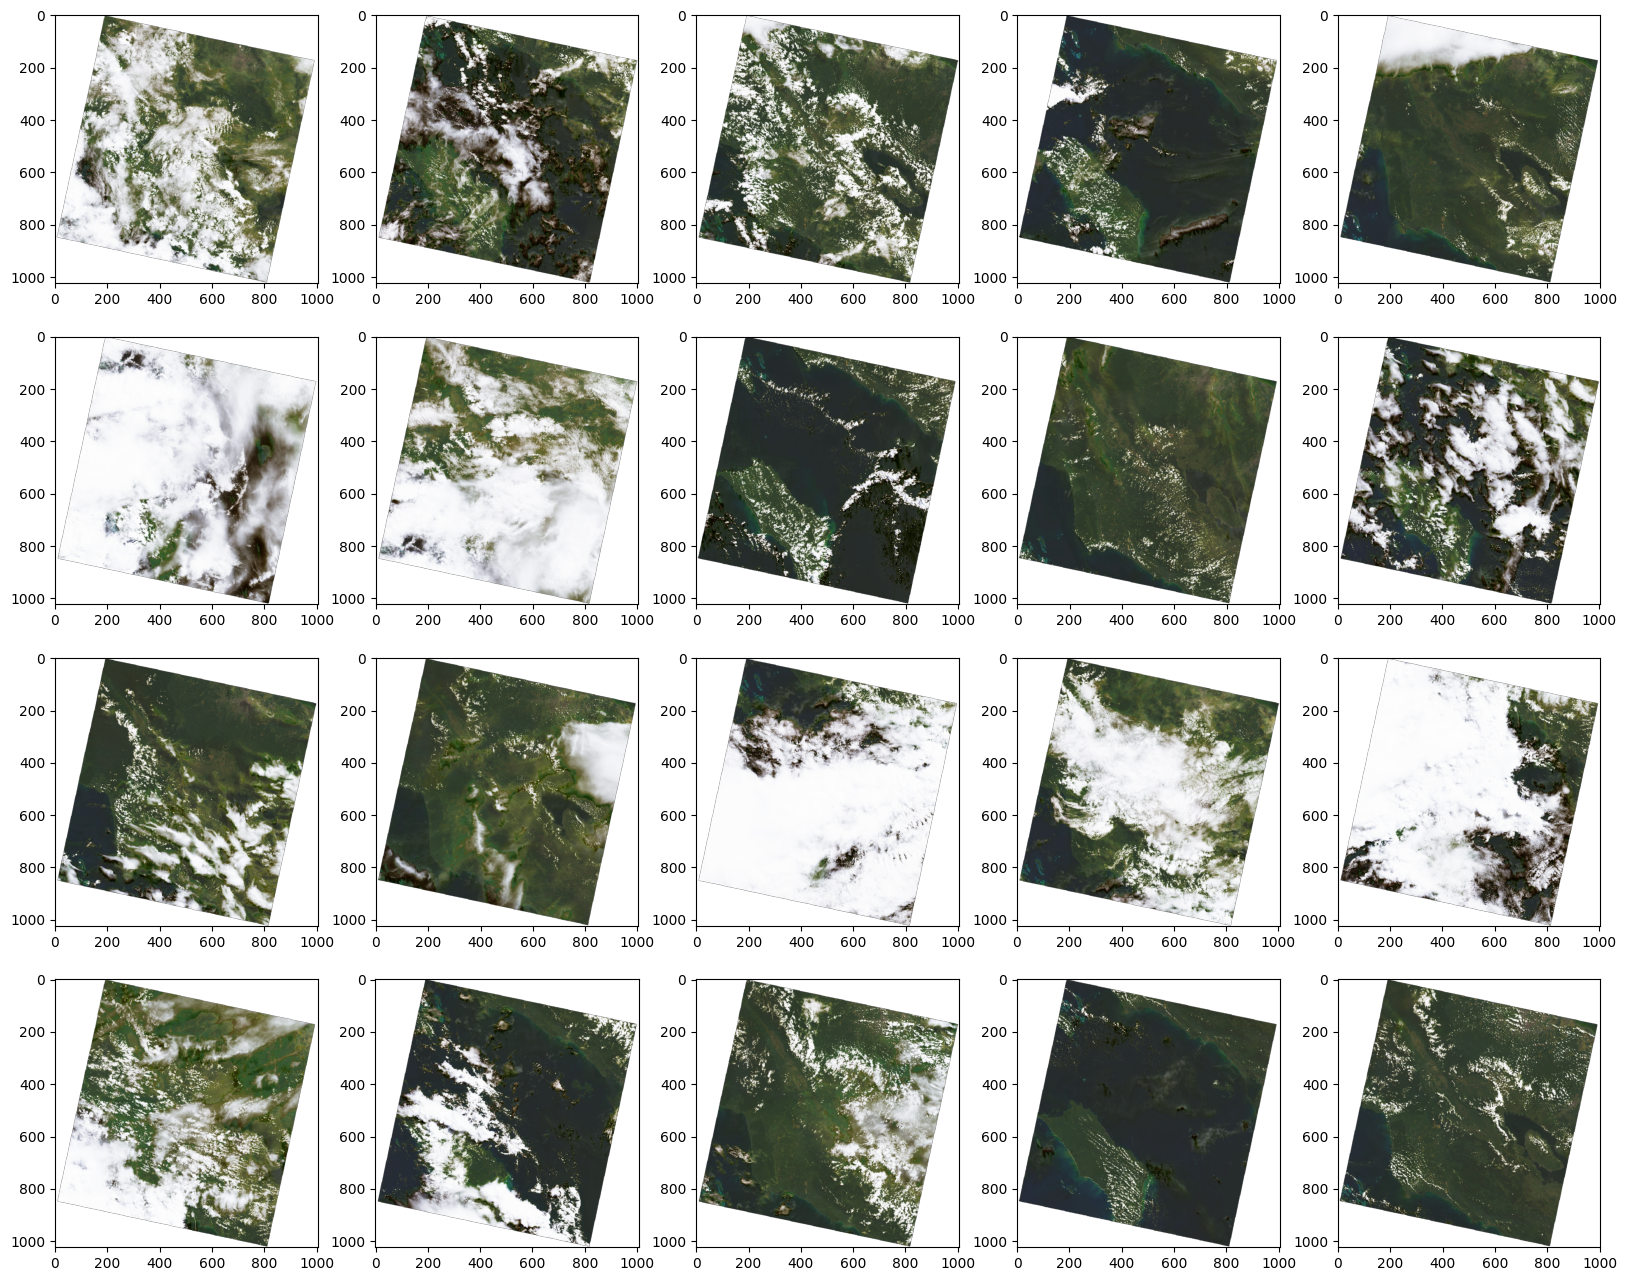

In [82]:
# Plot thumbnail every images
plt.figure(figsize=(20, 16))

# Load as plot
# Only the first 10
for x in range(0, len(data_list)):
	if (x < 20):
		dict = data_list[x]
		thumbnail = dict['assets']['rendered_preview']['href']
		image = ski.io.imread(thumbnail)
		plt.subplot(4, 5, x + 1)
		plt.imshow(image)

C:\Users\ramiq\AppData\Local\Temp\ipykernel_9124\557577932.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))


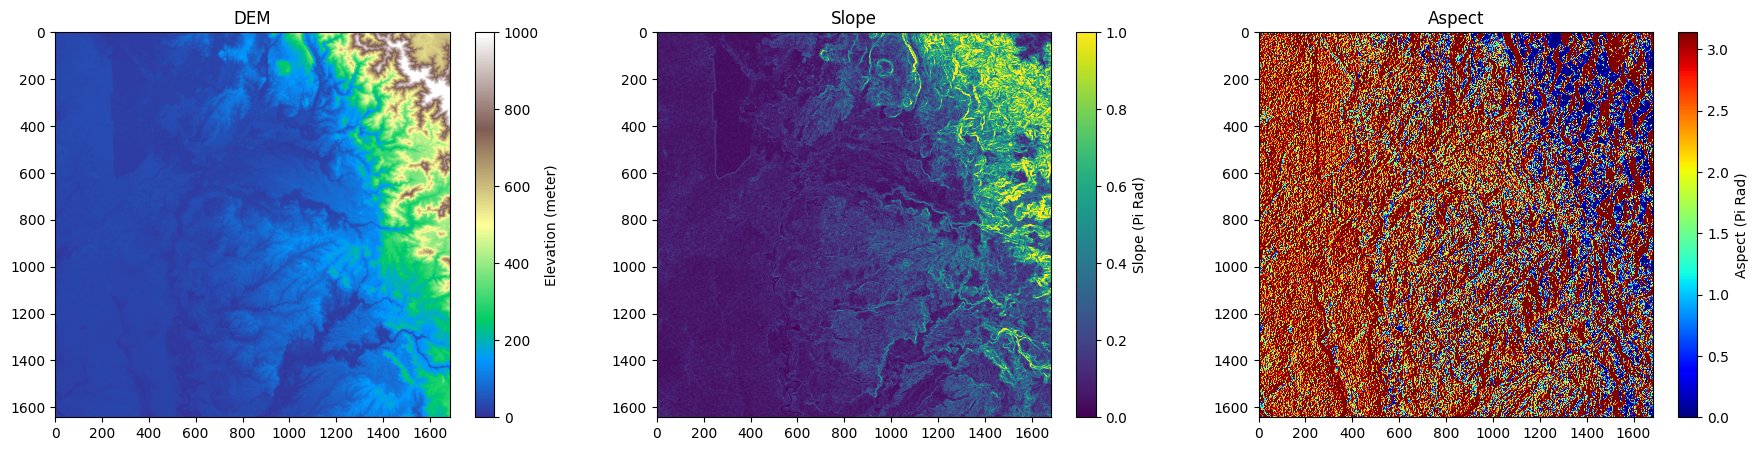

In [174]:
# Search DEM data
dem_data_search = client.search(
	collections=['nasadem'],
	bbox=bbox
)

# Load DEM as rio
dem_sources = [rio.open(x['assets']['elevation']['href']) for x in dem_data_search.items_as_dicts()]

# Merge DEM
merge_dem, dem_transform = merge(dem_sources, bounds=(bbox[0], bbox[1], bbox[2], bbox[3]))
merge_dem = merge_dem[0]

# DEM shape
dem_shape = merge_dem.shape

# Plot
plt.figure(figsize=(22, 5))

# Plot DEM
plt.subplot(1, 3, 1)
plt.title('DEM')
plt.imshow(merge_dem, vmin=0, vmax=1000, cmap='terrain')
plt.colorbar(label='Elevation (meter)')

# Pi
pi = 3.14159265359

# Make slope
px, py = np.gradient(merge_dem, 30)
slope = np.sqrt((px ** 2) + (py ** 2))
slope_deg = slope / 1 * 90
slope_rad = slope_deg / 180 * pi
plt.subplot(1, 3, 2)
plt.title('Slope')
plt.imshow(slope_rad, vmin=0, vmax=1)
plt.colorbar(label='Slope (Pi Rad)')

# Make aspect
aspect = np.arctan2(py, -px)
aspect_normalized = 90 - aspect.copy()
aspect_normalized = np.where(aspect < 0, aspect_normalized, 90 - aspect_normalized)
aspect_normalized = np.where(aspect > 0, aspect_normalized, 360 - aspect_normalized + 90)
aspect_rad = aspect_normalized / 180 * pi

plt.subplot(1, 3, 3)
plt.title('Aspect')
plt.imshow(aspect_rad, vmin=0, vmax=3.14, cmap='jet')
plt.colorbar(label='Aspect (Pi Rad)')

In [ ]:
# Load the tif images
plt.figure(figsize=(20, 10))

# Select the bands needed
bands = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
qband = 'qa_pixel'

# Load bands
cloud_masked_images = []
for x in range(0, len(data_list)):
	# Get dict of data in the items
	assets = data_list[x]['assets']

	# Read asset properties
	properties = data_list[x]['properties']

	# Get the angle parameter for topographic correction
	azimuth_rad = properties['view:sun_azimuth'] * pi / 180
	elevation = properties['view:sun_elevation']
	zenith_rad = (elevation - 90) * pi / 180

	# Another parameter for topographic correction
	cos_zenith = np.cos(zenith_rad)
	cos_slope = np.cos(slope_rad)
	slope_illumination = cos_zenith * cos_slope
	sin_zenith = np.sin(zenith_rad)
	sin_slope = np.sin(slope_rad)
	cos_azmiuth_dif = np.cos(azimuth_rad - aspect_rad)
	aspect_illumination = sin_zenith * sin_slope * cos_azmiuth_dif
	incidence_angle = slope_illumination + aspect_illumination

# 	# Get the quality band
# 	qband_source = rio.open(assets[qband]['href'])

# 	# Make window to read file only on specific part
# 	# Using our ROI BBOX to limit read
# 	transform = qband_source.transform

# 	# Create a bbox based on the CRS of the image
# 	bbox_small = roi.to_crs(qband_source.crs).bounds.iloc[0]

# 	# Window to read the imagew
# 	window = rio.windows.from_bounds(bbox_small[0], bbox_small[1], bbox_small[2], bbox_small[3], transform)

# 	# Qband raster
# 	qband_image = qband_source.read(1, window=window, boundless=True, fill_value=1, out_shape=(dem_shape[0], dem_shape[1]))

# 	# Make cloud mask
# 	cloud_mask = (qband_image != 1) & ((qband_image & (1 << 1)) == 0) & ((qband_image & (1 << 2)) == 0) & ((qband_image & (1 << 3)) == 0)

# 	# Cloud masked image
# 	# Load source each band
# 	sources = [rio.open(assets[y]['href']) for y in bands]

# 	# Make into 1 stack
# 	stack = np.stack([source.read(1, window=window, boundless=True, fill_value=-9999, out_shape=(dem_shape[0], dem_shape[1])) for source in sources]) * 0.0000275 + -0.2

# 	# Apply cloud mask per band
# 	for y in range(0, len(stack)):
# 		stack[y][cloud_mask == 0] = -9999

# 	# Add each image to the list of images
# 	cloud_masked_images.append(stack)

# 	# Make composite using NIR SWIR1 SWIR2
# 	# Only 20 bands
# 	if (x < 20):
# 		# Make range into 0 - 1
# 		out_range = (0, 1)
# 		composite = np.dstack([
# 			rescale_intensity(stack[4], in_range=(0.1, 0.4), out_range=out_range),
# 			rescale_intensity(stack[5], in_range=(0.05, 0.3), out_range=out_range),
# 			rescale_intensity(stack[6], in_range=(0.025, 0.25), out_range=out_range),
# 		])

# 		# Plot
# 		plt.subplot(4, 5, x + 1)
# 		plt.imshow(composite)

# # Make list of images as numpy stack
# cloud_masked_images = np.stack(cloud_masked_images)
# cloud_masked_images.shape

[[-0.04682118 -0.01548205 -0.0183499  ... -0.04306266 -0.03882591
  -0.09312937]
 [-0.04682118 -0.01548205 -0.03514399 ... -0.06882763 -0.05392015
  -0.0460041 ]
 [-0.03514399 -0.03514399 -0.00873176 ... -0.09505411 -0.07502463
  -0.06508253]
 ...
 [-0.02695069 -0.03439687 -0.02885181 ... -0.05931122 -0.05430703
  -0.05083013]
 [-0.02523331 -0.03421907 -0.02876548 ... -0.04521107 -0.03684884
  -0.04125378]
 [-0.03745688 -0.0390394  -0.01885754 ... -0.03222627 -0.04679988
  -0.0565676 ]]
[[-0.04751574 -0.02276946 -0.0271726  ... -0.06260361 -0.05668537
  -0.09451088]
 [-0.04751574 -0.02276946 -0.03566533 ... -0.10017624 -0.07870532
  -0.06720057]
 [-0.03566533 -0.03566533 -0.01269405 ... -0.13844744 -0.10926128
  -0.09496796]
 ...
 [-0.03879454 -0.04943581 -0.0413345  ... -0.08387584 -0.07702781
  -0.07241947]
 [-0.03599137 -0.04875312 -0.04112632 ... -0.06455489 -0.05268319
  -0.05889687]
 [-0.05320346 -0.05526549 -0.0267851  ... -0.04642715 -0.06725167
  -0.08087531]]
[[-0.04718905 -0

<Figure size 2000x1000 with 0 Axes>

C:\Users\ramiq\AppData\Local\Temp\ipykernel_9124\4025246850.py:3: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(masked_images, 0)


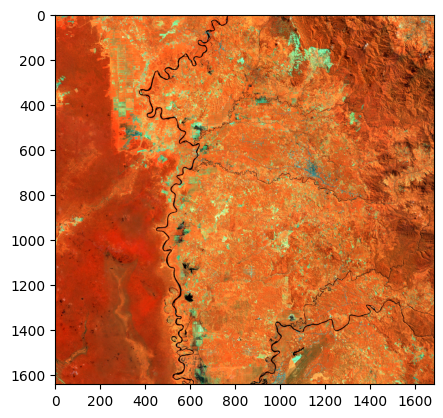

In [75]:
# Median composit along its 0 axis
masked_images = np.ma.masked_where(cloud_masked_images < 0, cloud_masked_images)
median = np.nanmedian(masked_images, 0)

# Composite median for visualization
composite = np.dstack([
	rescale_intensity(median[4], in_range=(0.1, 0.4), out_range=(0, 1)),
	rescale_intensity(median[5], in_range=(0.05, 0.3), out_range=(0, 1)),
	rescale_intensity(median[6], in_range=(0.025, 0.25), out_range=(0, 1))
])

plt.imshow(composite)

In [77]:
# Save image as geotiff
int_image = median * 1e4
int_image[median < 0] = -9999
output = rio.open(
	'../data/result/cloudmasked_landsat_composite.tif',
	'w',
	'COG',
	count=median.shape[0],
	width=median.shape[2],
	height=median.shape[1],
	crs=roi.crs,
	transform=rio.transform.from_bounds(*bbox, width=median.shape[2], height=median.shape[1]),
	nodata=-9999,
	dtype='uint16',
	compress='lzw',
	resampling=Resampling.bilinear
)
output.write(int_image)
output.descriptions = tuple(['COASTAL', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
output.close()

c:\Users\ramiq\Learning\remote-sensing-python\.venv\Lib\site-packages\numpy\_core\_asarray.py:127: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=None, subok=subok)
